Malicious DNS to TCP Supervised regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("Malicious DNS to TCP.csv")

In [3]:
print("Existing column names:", df.columns)

Existing column names: Index(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort',
       'TimeStamp', 'Duration', 'FlowBytesSent', 'FlowSentRate',
       'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'DoH'],
      dtype='object')


In [4]:
dataset_cols = [
    "SourcePort", #Port numbers associated with the source endpoints of the network flow.
        "DestinationPort", #Port numbers associated with the destination endpoints of the network flow.
        "Duration", #Duration of the network flow.
        "FlowBytesSent", #Number of bytes sent in the network flow.
        "FlowSentRate", #Rate at which bytes are sent in the network flow.
        "FlowBytesReceived", #Number of bytes received in the network flow.
        "FlowReceivedRate", #Rate at which bytes are received in the network flow.
        "PacketTimeCoefficientofVariation", #Calculates the coefficient of variation for the time intervals between packets in a data communication or networking context.
        "ResponseTimeTimeVariance", #Calculates the variance of response times in a system or application.
        "ResponseTimeTimeStandardDeviation", #Calculates the standard deviation of response times in a system or application. 
        "ResponseTimeTimeMean",#Calculates the mean (average) of response times in a system or application.
        "ResponseTimeTimeMedian", #Calculates the median of response times in a system or application.
        "ResponseTimeTimeMode", #Calculates the mode of response times in a system or application.
        "ResponseTimeTimeSkewFromMedian",#calculates the skewness of response times in relation to the median in a system or application, where skewness is a statistical measure that indicates the asymmetry of a probability distribution.
        "ResponseTimeTimeSkewFromMode", #Measurement of how the distribution of response times is skewed in relation to the mode which is the most frequently occurring value in a dataset.
        "ResponseTimeTimeCoefficientofVariation", #Useful for understanding how consistent or variable the system's response times are.
        "DoH" #DoH stands for DNS over HTTPS and is a protocol that enhances the security and privacy of DNS (Domain Name System) queries by encrypting the DNS traffic and sending it over the HTTPS protocol.
]

In [5]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH
0,192.168.20.209,1.1.1.1,39406,443,2020-04-01 22:55:13,120.772871,42357,350.716180,71915,595.456574,...,0.489724,4.023502e-01,0.634311,0.163861,0.001734,0.000006,0.766785,0.258319,3.871039,True
1,1.1.1.1,192.168.20.209,443,39406,2020-04-01 22:57:14,120.656643,78950,654.336123,46138,382.390881,...,0.617101,1.243765e-08,0.000112,0.000050,0.000034,0.000021,0.433249,0.260983,2.225769,True
2,1.1.1.1,192.168.20.209,443,39406,2020-04-01 22:59:15,120.692061,78559,650.904453,46805,387.805127,...,0.617322,8.999716e-09,0.000095,0.000046,0.000031,0.000024,0.471856,0.231073,2.065863,True
3,1.1.1.1,192.168.20.209,443,39406,2020-04-01 23:01:15,120.644016,78133,647.632619,46444,384.967291,...,0.608922,7.678121e-09,0.000088,0.000048,0.000035,0.000021,0.444360,0.307892,1.826318,True
4,1.1.1.1,192.168.20.209,443,39406,2020-04-01 23:03:16,120.883686,79169,654.918812,47193,390.400074,...,0.615777,1.310879e-08,0.000114,0.000048,0.000030,0.000018,0.470369,0.261599,2.387701,True


In [6]:
if len(df.columns) != len(dataset_cols): #Checks whether the number of columns in the DataFrame df is equal to the number of columns specified in the dataset_cols list.
    print("Column count mismatch. Adjust the dataset_cols list or DataFrame.")
else:
    df = df[dataset_cols] #Selects only the columns specified in the dataset_cols list from the DataFrame df, effectively filtering the DataFrame to include only those columns.
    df["ResponseTimeTimeMedian"] = df["ResponseTimeTimeMedian"].astype(bool) #Converts the values in the "ResponseTimeTimeMedian" column to boolean values (True or False). 
    df = df[df["FlowReceivedRate"] == 12] #Filters the DataFrame df to include only the rows where the value in the "FlowReceivedRate" column is equal to 12, which effectively narrows down the DataFrame to only those rows where the "FlowReceivedRate" is 12.
    df = df.drop(["FlowReceivedRate"], axis=1) #Removes the "FlowReceivedRate" column from the DataFrame df, as this is dropped from the DataFrame, and it won't be present in the DataFrame after this step.

Column count mismatch. Adjust the dataset_cols list or DataFrame.


In [7]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH
0,192.168.20.209,1.1.1.1,39406,443,2020-04-01 22:55:13,120.772871,42357,350.716180,71915,595.456574,...,0.489724,4.023502e-01,0.634311,0.163861,0.001734,0.000006,0.766785,0.258319,3.871039,True
1,1.1.1.1,192.168.20.209,443,39406,2020-04-01 22:57:14,120.656643,78950,654.336123,46138,382.390881,...,0.617101,1.243765e-08,0.000112,0.000050,0.000034,0.000021,0.433249,0.260983,2.225769,True
2,1.1.1.1,192.168.20.209,443,39406,2020-04-01 22:59:15,120.692061,78559,650.904453,46805,387.805127,...,0.617322,8.999716e-09,0.000095,0.000046,0.000031,0.000024,0.471856,0.231073,2.065863,True
3,1.1.1.1,192.168.20.209,443,39406,2020-04-01 23:01:15,120.644016,78133,647.632619,46444,384.967291,...,0.608922,7.678121e-09,0.000088,0.000048,0.000035,0.000021,0.444360,0.307892,1.826318,True
4,1.1.1.1,192.168.20.209,443,39406,2020-04-01 23:03:16,120.883686,79169,654.918812,47193,390.400074,...,0.615777,1.310879e-08,0.000114,0.000048,0.000030,0.000018,0.470369,0.261599,2.387701,True


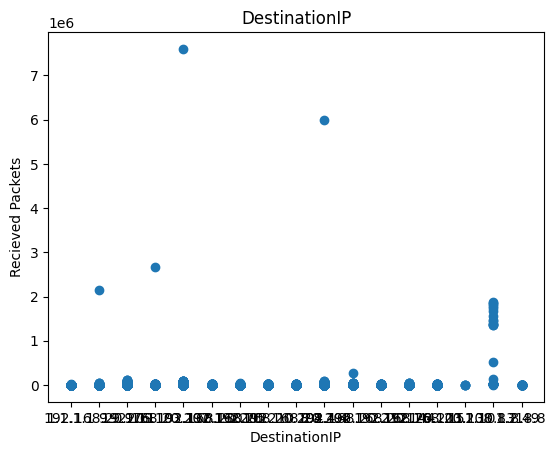

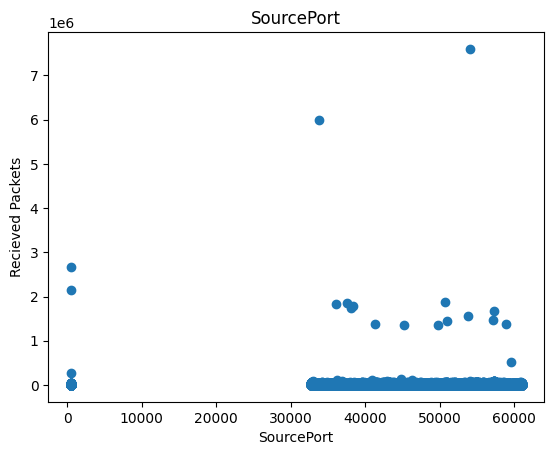

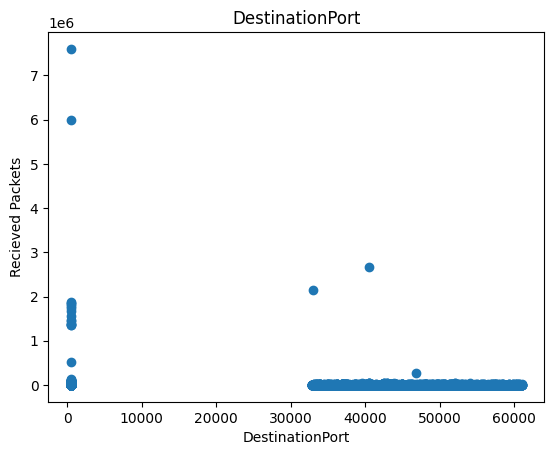

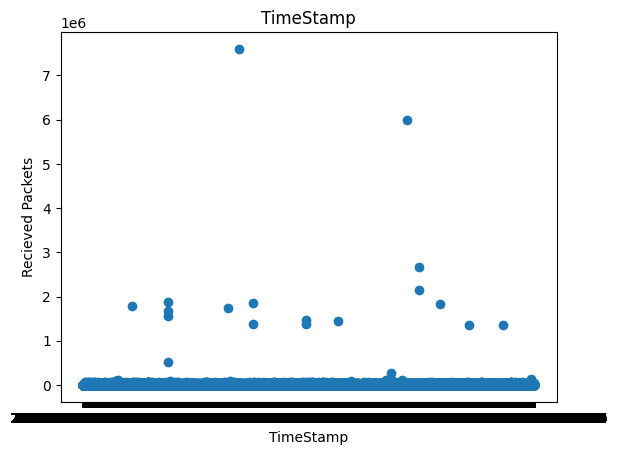

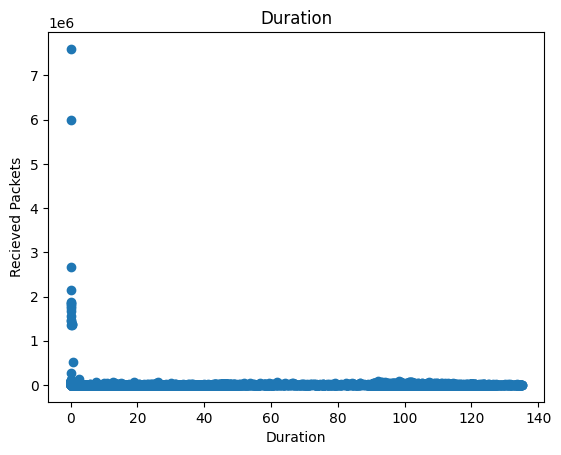

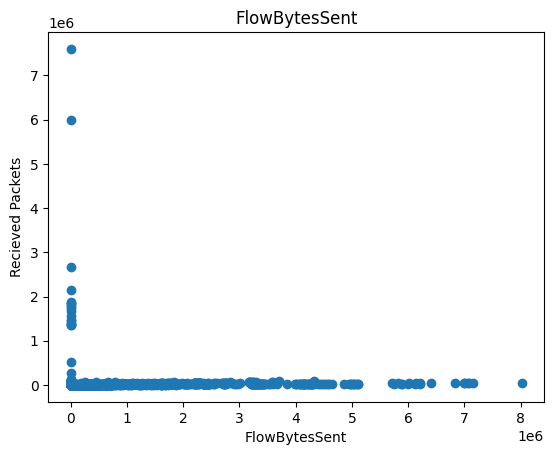

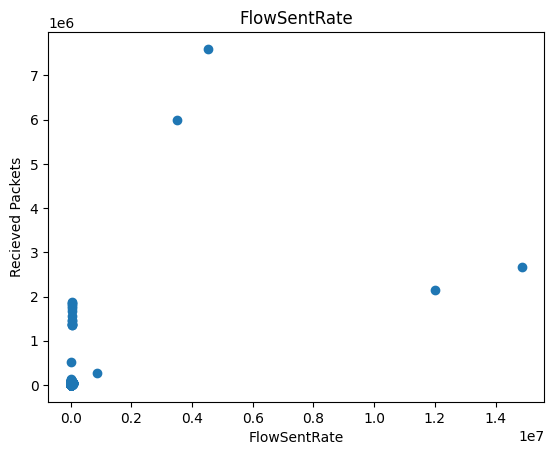

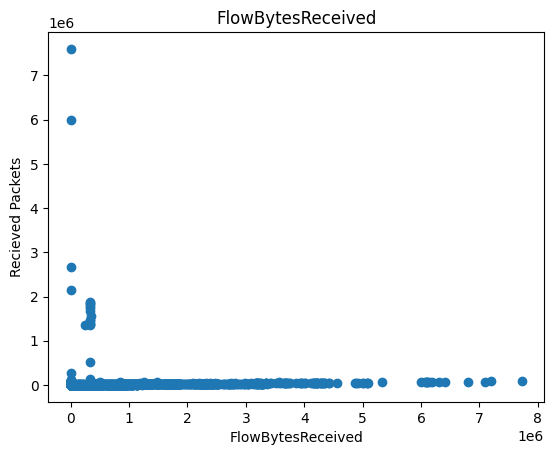

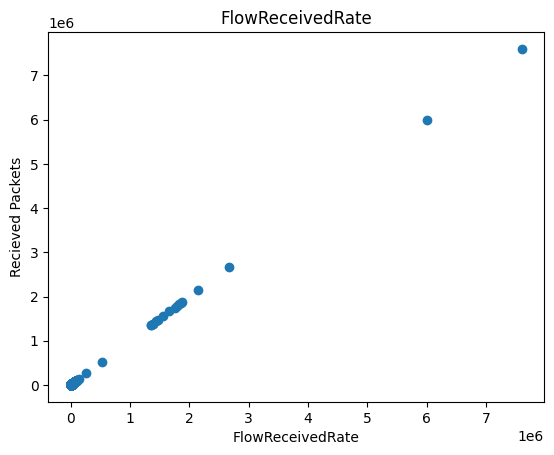

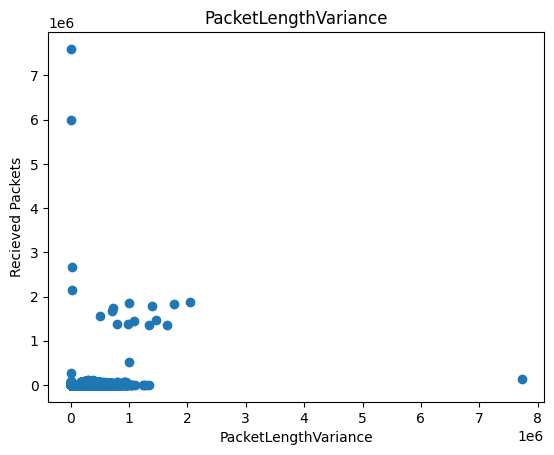

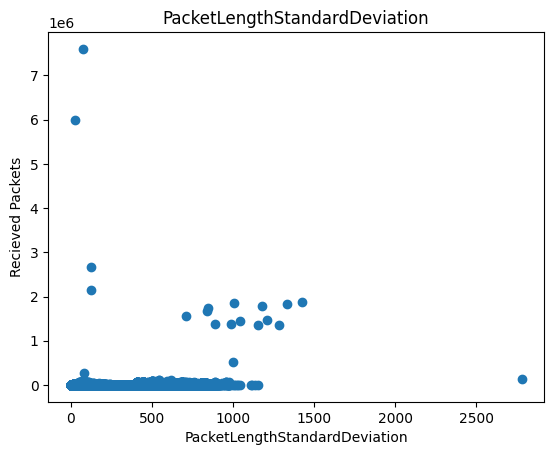

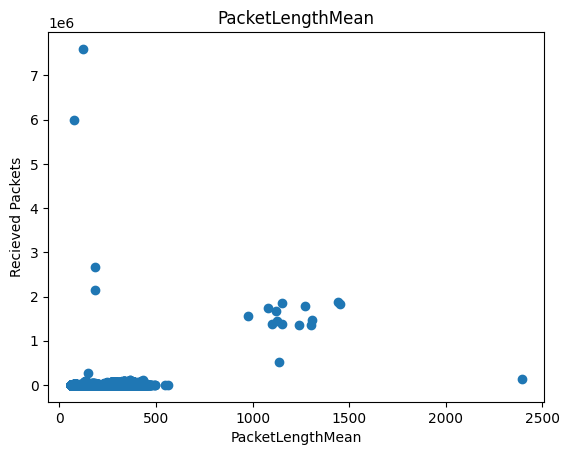

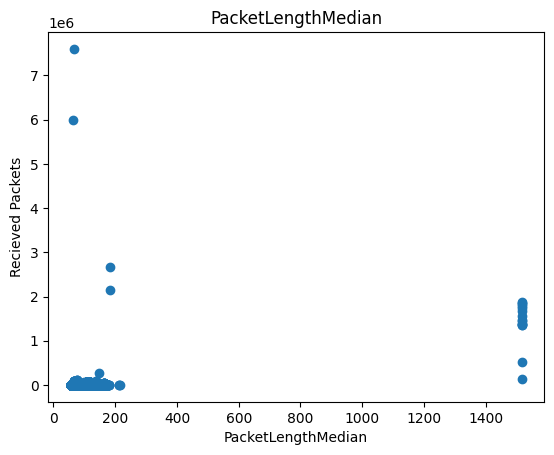

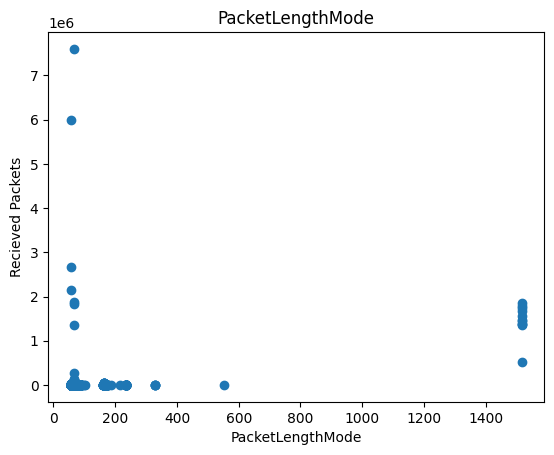

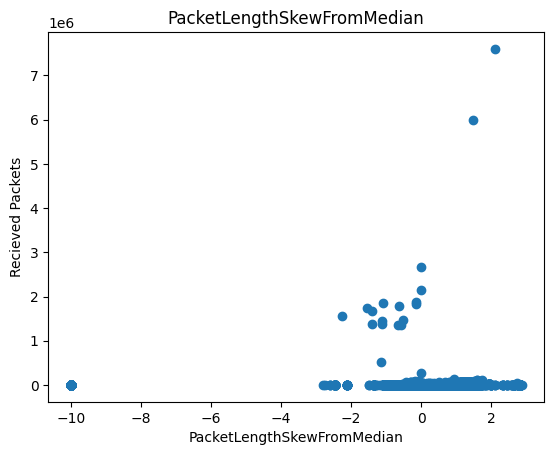

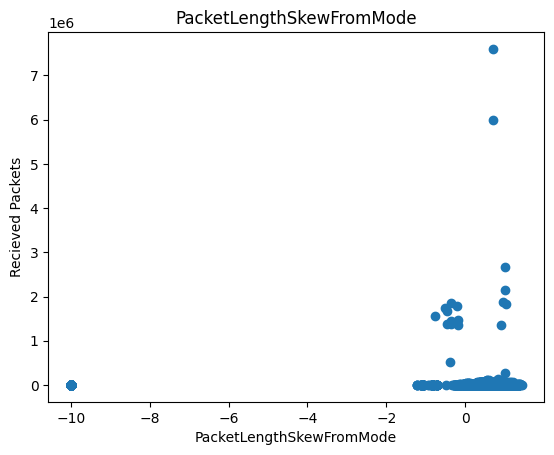

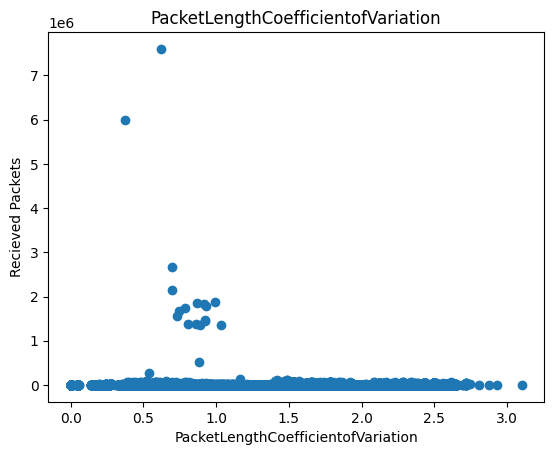

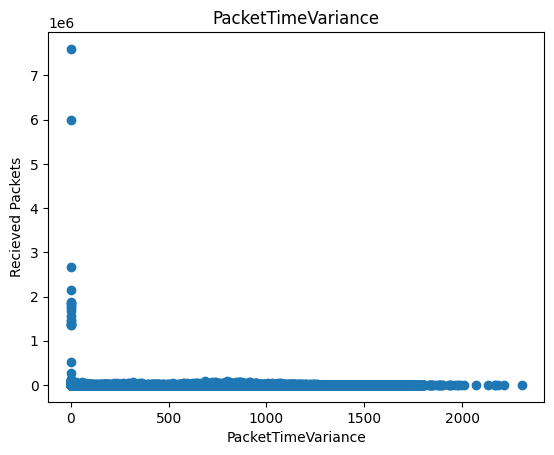

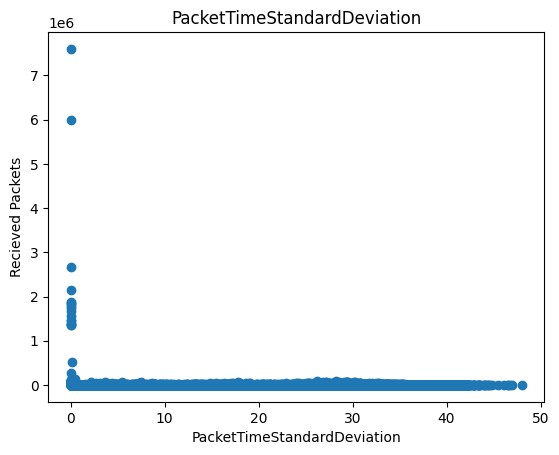

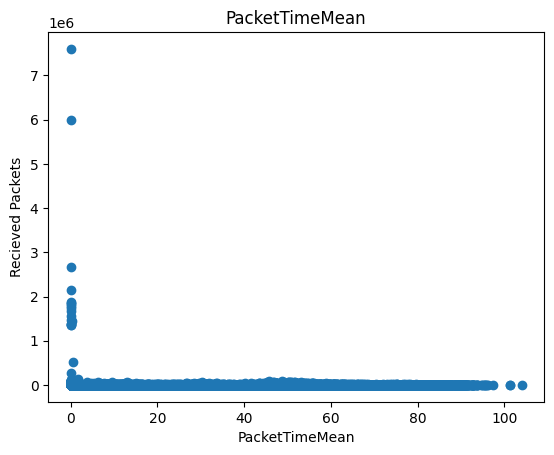

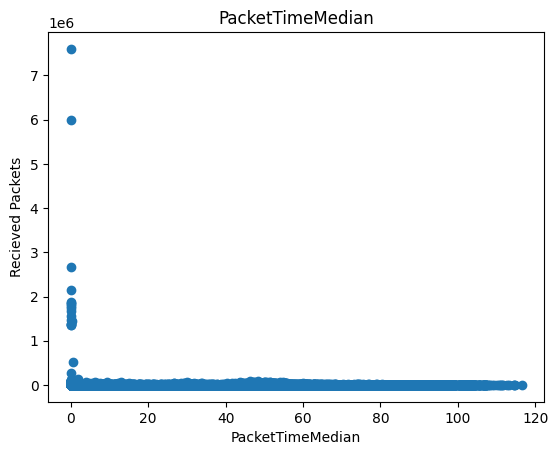

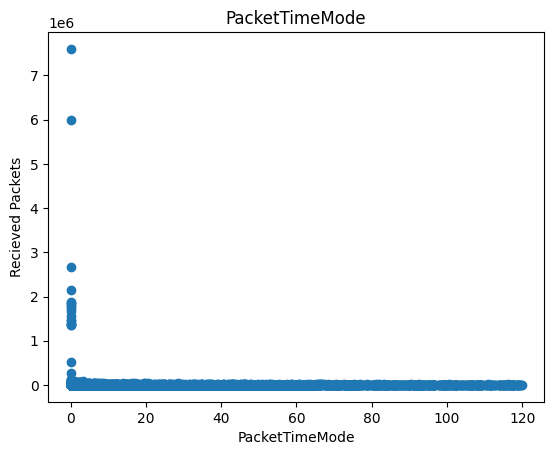

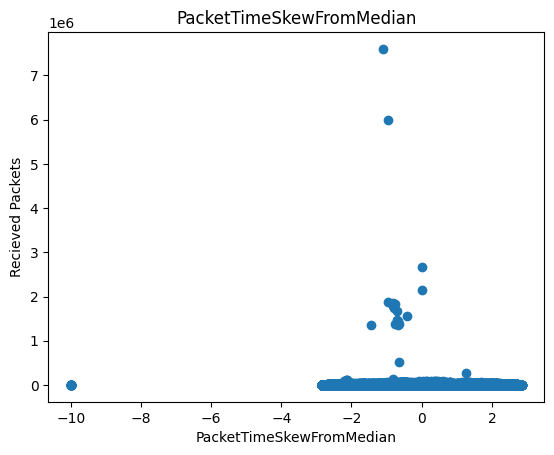

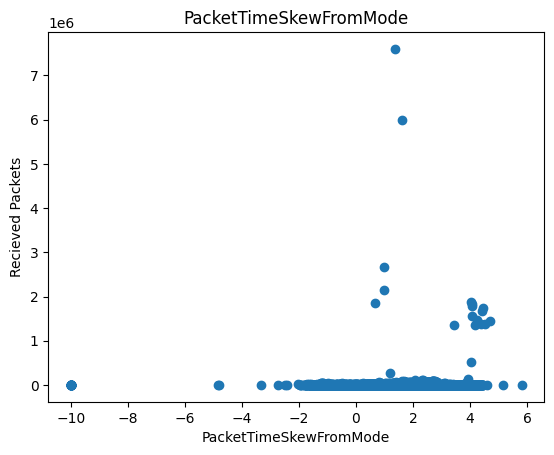

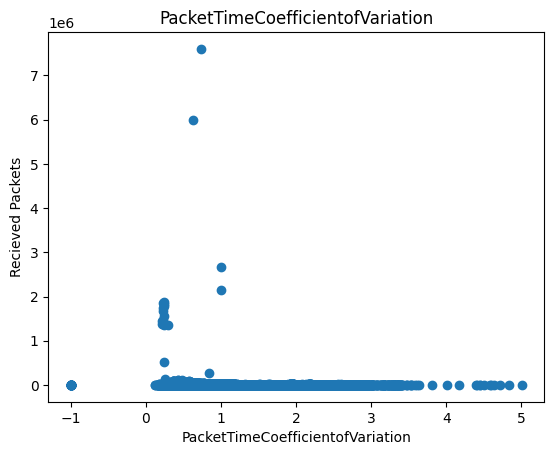

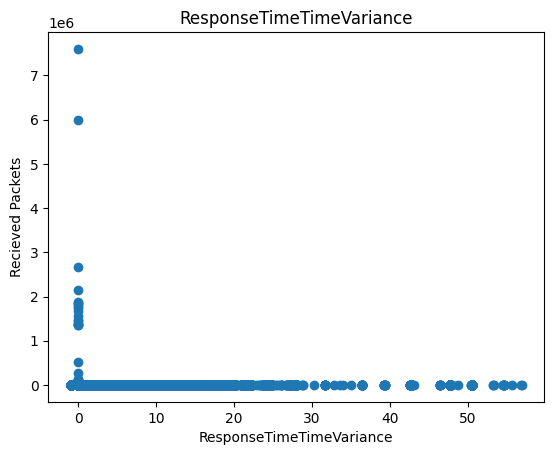

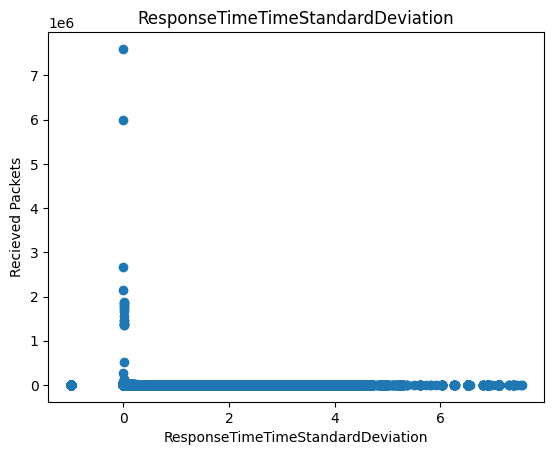

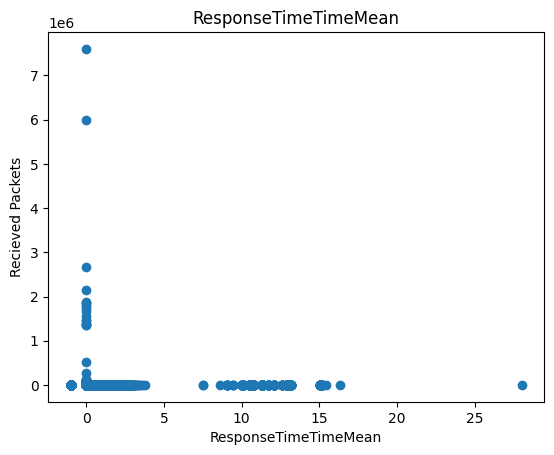

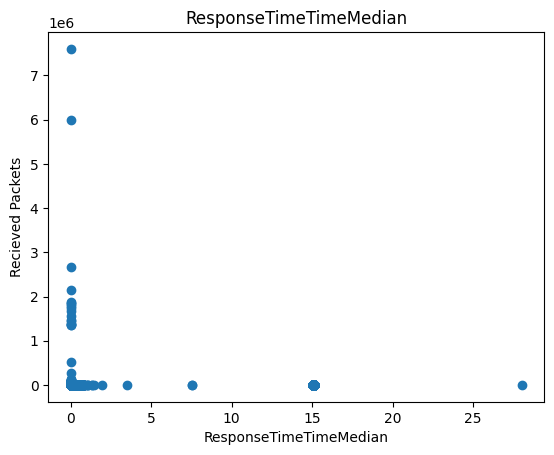

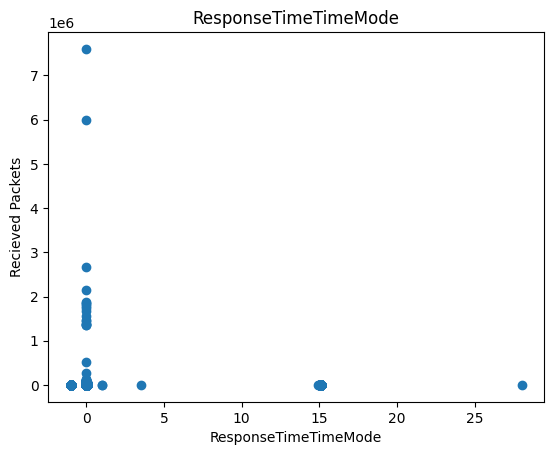

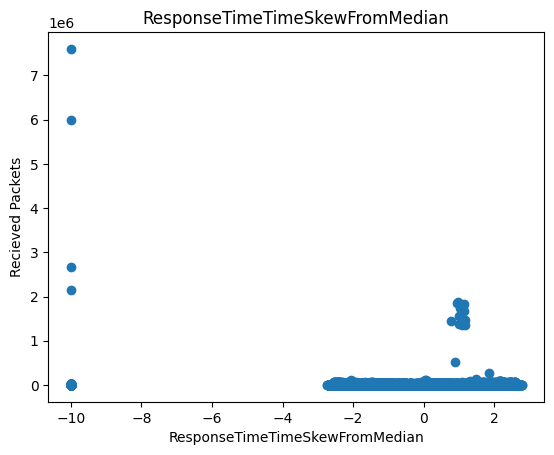

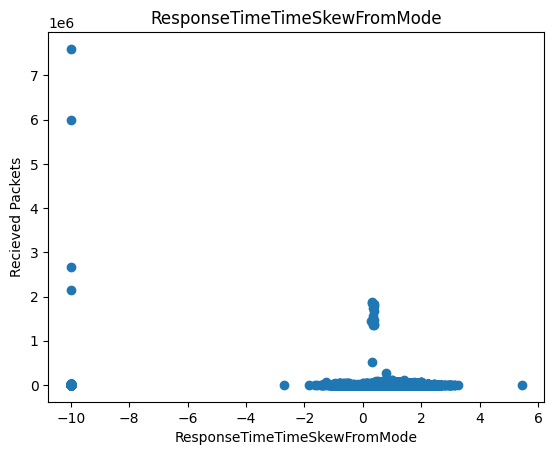

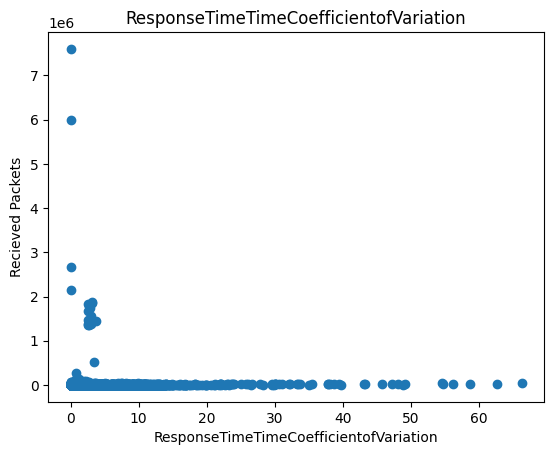

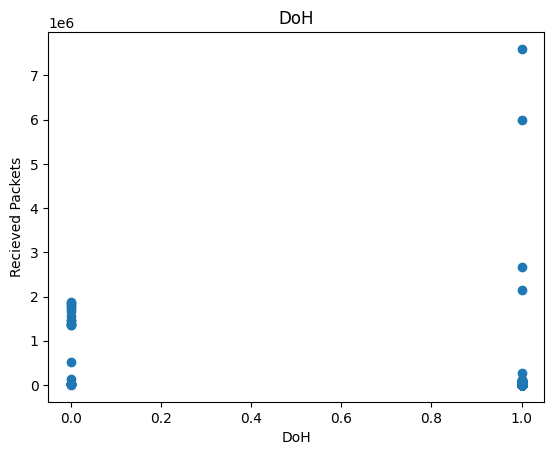

In [8]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["FlowReceivedRate"])
  plt.title(label)
  plt.ylabel("Recieved Packets")
  plt.xlabel(label)
  plt.show()

In [9]:
df = df.drop(["TimeStamp", "Duration", "SourceIP"], axis=1)

In [10]:
df.head()

,DestinationIP,SourcePort,DestinationPort,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH
0,1.1.1.1,39406,443,42357,350.716180,71915,595.456574,14259.237470,119.412049,126.128035,...,0.489724,4.023502e-01,0.634311,0.163861,0.001734,0.000006,0.766785,0.258319,3.871039,True
1,192.168.20.209,443,39406,78950,654.336123,46138,382.390881,8233.235012,90.737175,121.918129,...,0.617101,1.243765e-08,0.000112,0.000050,0.000034,0.000021,0.433249,0.260983,2.225769,True
2,192.168.20.209,443,39406,78559,650.904453,46805,387.805127,8366.058296,91.466159,122.545455,...,0.617322,8.999716e-09,0.000095,0.000046,0.000031,0.000024,0.471856,0.231073,2.065863,True
3,192.168.20.209,443,39406,78133,647.632619,46444,384.967291,9630.887087,98.137083,123.465808,...,0.608922,7.678121e-09,0.000088,0.000048,0.000035,0.000021,0.444360,0.307892,1.826318,True
4,192.168.20.209,443,39406,79169,654.918812,47193,390.400074,8165.728177,90.364419,121.268714,...,0.615777,1.310879e-08,0.000114,0.000048,0.000030,0.000018,0.470369,0.261599,2.387701,True


In [11]:
#Removes the columns "TimeStamp", "Duration", and "SourceIP" from the DataFrame df.
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [12]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe) #A deep copy of the input DataFrame is created using the copy.deepcopy() function, to ensure that modifications made to the DataFrame within the function don't affect the original DataFrame outside the function.
  if x_labels is None: #Checks whether x_labels is None (not provided) where if x_labels is not provided, it means that all columns except the one specified by y_label should be used as features.
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values #To ensure that the feature matrix X has a compatible shape for machine learning algorithms that expect a 2D feature matrix.
  else:
    if len(x_labels) == 1: #If x_labels contains more than one label the corresponding columns' values are directly extracted and assigned to the feature matrix X.
      X = dataframe[x_labels[0]].values.reshape(-1, 1) #The target variable's values are extracted from the dataframe using the label provided in y_label, and the values are reshaped into a 2D array with a single column.
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y)) #Used to horizontally stack the feature matrix X and the target variable y to create a combined dataset array named data.

  return data, X, y

In [13]:
_, X_train, y_train = get_xy(train, "FlowReceivedRate", x_labels=["PacketLengthMode"]) #Prepares the data for machine learning training, validation, and testing sets by extracting the necessary feature and target variables.
_, X_val, y_val = get_xy(val, "FlowReceivedRate", x_labels=["PacketLengthMode"]) #Extracts the feature matrix X and target variable y for the target variable "FlowReceivedRate," using only the feature labeled "PacketLengthMode."
_, X_test, y_test = get_xy(test, "FlowReceivedRate", x_labels=["PacketLengthMode"])

In [14]:
#After these two lines of code are executed, the variable train_reg will hold a trained linear regression model that has learned the relationships between the input feature(s) and the target variable based on the training data. 
#This model can then be used to make predictions on new, unseen data.
train_reg = LinearRegression()
train_reg.fit(X_train, y_train)

LinearRegression()

In [15]:
#Computes the R-squared score of a trained linear regression model on a specific test dataset, providing an indication of how well the model's predictions match the actual target values.
train_reg.score(X_test, y_test)

-0.04659476291855125

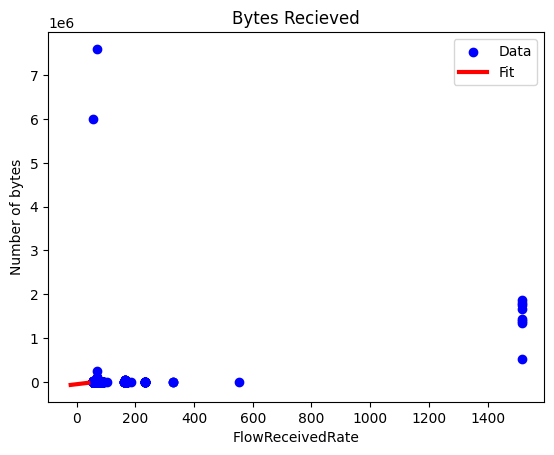

In [16]:
plt.scatter(X_train, y_train, label="Data", color="blue") #Plots the data points where X_train are on the x-axis and y_train are on the y-axis, as each point is represented as a blue dot, and the label is used for this set of points.
x = tf.linspace(-20, 40, 100) #Generates an array x of 100 equally spaced points between -20 and 40 to cover a reasonable range 
plt.plot(x, train_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3) #Plots the predicted values from the trained linear regression model as a red line. 
plt.legend() #Adds a legend to the plot based on the labels specified in the scatter and plot functions.
plt.title("Bytes Recieved") #Sets the title of the plot
plt.ylabel("Number of bytes") #Labels the y-axis
plt.xlabel("FlowReceivedRate") # Labels the x-axis
plt.show() #Displays the plot on the screen.

In [17]:
#Divides the original DataFrame df into training, validation, and testing datasets to extract the feature and target variables using the get_xy function, considering all columns (except the first one) as features. 
#This process prepares the data for training, validation, and testing of machine learning models.
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "FlowReceivedRate", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "FlowReceivedRate", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "FlowReceivedRate", x_labels=df.columns[1:])

In [18]:
all_reg = LinearRegression() #Represents a linear regression model, which is a supervised machine learning algorithm used for predicting a continuous target variable based on one or more input features.
all_reg.fit(X_train, y_train_all) #Uses the fit method of the LinearRegression instance (all_reg) to train the model.

LinearRegression()

In [19]:
#Computes the R-squared score of a trained linear regression model on a specific test dataset providing an indication of how well the model's predictions match the actual target values helping to evaluate the model's performance on unseen data.
all_reg.score(X_test, y_test)

5.9351188737011285e-06

In [20]:
#The variable y_pred_lr will contain the predicted target variable values for the test dataset based on the trained linear regression model, which can be compared to the actual target values in the test dataset to evaluate the model's performance.
y_pred_lr = all_reg.predict(X_test)

In [21]:
def plot_loss(history): #Takes one argument which is expected to be an object containing training history information which can be obtained when training a machine learning model.
  plt.plot(history.history['loss'], label='loss') #Plots the training loss values over epochs using the stored
  plt.plot(history.history['val_loss'], label='val_loss') #Plots the validation loss values over epochs using the data stored within the object.
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend() #To differentiate between the training and validation loss lines.
  plt.grid(True) #Adds grid lines to the plot for better visualization.
  plt.show()

In [22]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) #This layer is used to normalize the input data making sure that the data has zero mean and unit variance.
temp_normalizer.adapt(X_train.reshape(-1)) #Learns the mean and variance of the training data, which will be used to normalize the data during subsequent operations.

In [23]:
temp_nn_model = tf.keras.Sequential([ #Creates an instance of a sequential neural network model using TensorFlow's Keras API.
    temp_normalizer, #Used as the first layer in the neural network model to normalize input data.
    tf.keras.layers.Dense(1) #A standard neural network layer where each neuron is connected to all neurons in the previous layer.
])

In [24]:
#Configures a neural network model for training using the TensorFlow and Keras API which specifies the optimizer and the loss function to be used during the training process.
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [25]:
history = temp_nn_model.fit( #To store the training history of the neural network model, including information about how the model's performance changes during training epochs. 
    X_train.reshape(-1), y_train, #The training feature matrix X_train is reshaped into a 1D array (vector)
    verbose=0, #The level of verbosity during training where a value of 0 means that no training progress will be displayed.
    epochs=200, #The model will be trained for 200 epochs which means it will go through the entire training dataset 200 times.
    validation_data=(X_val, y_val) #To monitor the model's performance during training.
)

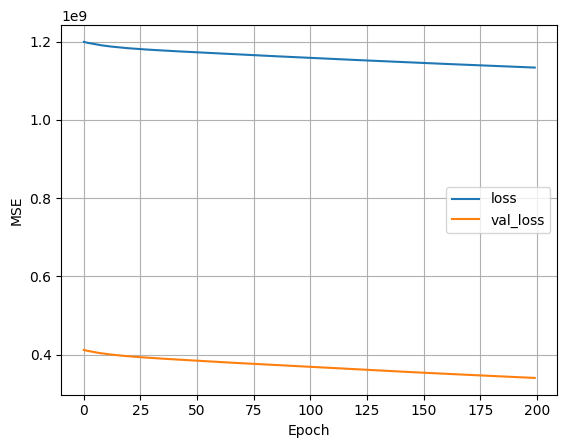

In [26]:
#The purpose of this code is to visualize how the loss values change over the course of training as this visualization helps in assessing whether the model is learning properly, and whether there are any signs of overfitting or underfitting. 
plot_loss(history)

4/4 [==============================] - 0s 667us/step


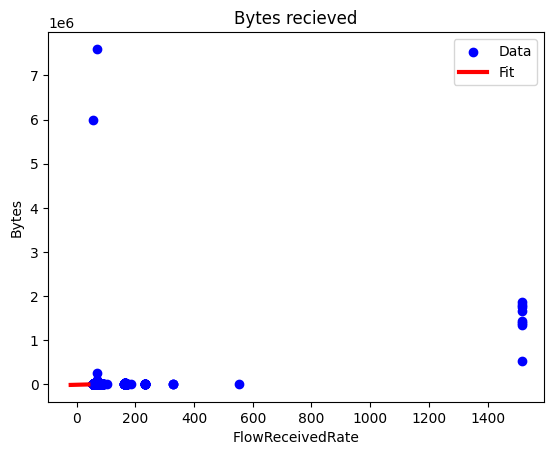

In [27]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = tf.linspace(-20, 40, 100) #Generates an array x of 100 equally spaced points between -20 and 40 to cover a reasonable range of FlowReceivedRate values. 
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bytes recieved")
plt.ylabel("Bytes")
plt.xlabel("FlowReceivedRate")
plt.show()

In [28]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) #Normalize the input data before passing it to the neural network.
temp_normalizer.adapt(X_train.reshape(-1)) # This line adapts the normalization layer to the training data to learn the mean and variance of the training data, which will be used to normalize the data during subsequent operations.

nn_model = tf.keras.Sequential([ #Creates an instance of a sequential neural network model using TensorFlow's Keras API.
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'), #Adds a dense layer to the neural network model. 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) #This line adds a dense layer with a single neuron which is suitable for regression tasks where the model predicts a single continuous value.
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error') #Compiles the neural network model by setting the optimizer and loss function for training.

In [29]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=200
)

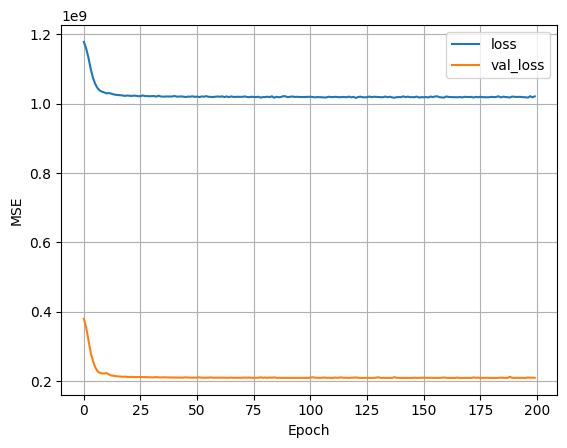

In [30]:
plot_loss(history)

4/4 [==============================] - 0s 1000us/step


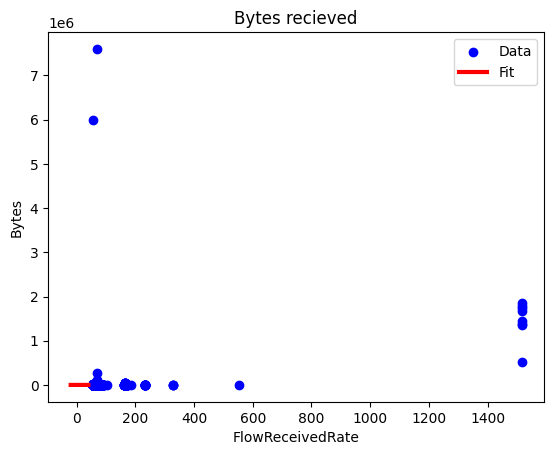

In [32]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bytes recieved")
plt.ylabel("Bytes")
plt.xlabel("FlowReceivedRate")
plt.show()

In [33]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1) #This layer is used to normalize the input data before feeding it into a neural network.
all_normalizer.adapt(X_train) #Learns the mean and variance of the training data, which will be used to normalize the data during subsequent operations.

In [34]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [35]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=100
)

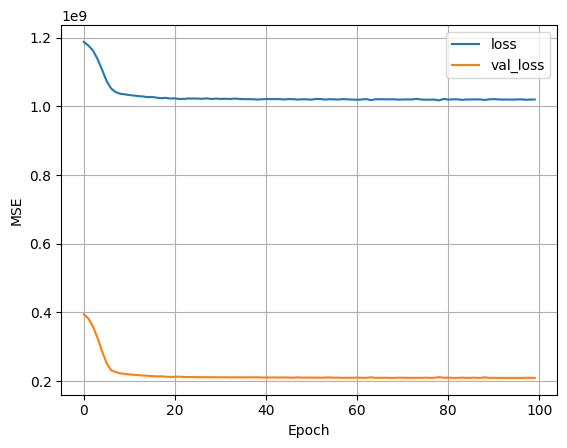

In [36]:
plot_loss(history)

In [37]:
y_pred_lr = all_reg.predict(X_test) #Uses the trained linear regression model to make predictions on the test data.
y_pred_nn = nn_model.predict(X_test) #Uses the trained neural network model (nn_model) to make predictions on the same test data 

1047/1047 [==============================] - 1s 511us/step


In [38]:
def MSE(y_pred, y_real): #The MSE function allows users to quantitatively measure the quality of predictions made by different models by comparing their predicted values to the actual values.
  return (np.square(y_pred - y_real)).mean() #The resulting value represents the average squared difference between the predicted and actual values, where the lower the MSE the closer the predicted values are to the actual values, indicating a better-fitting model.

In [39]:
#The result of this code will be a numerical value representing the mean squared error between the predicted values generated by the linear regression model and the actual target values. 
#This metric quantifies how well the model's predictions match the actual data and can be used to evaluate the performance of the linear regression model on the test dataset.
MSE(y_pred_lr, y_test_all)

428002310.1698468

In [40]:
MSE(y_pred_nn, y_test_all)

428327735.99033666

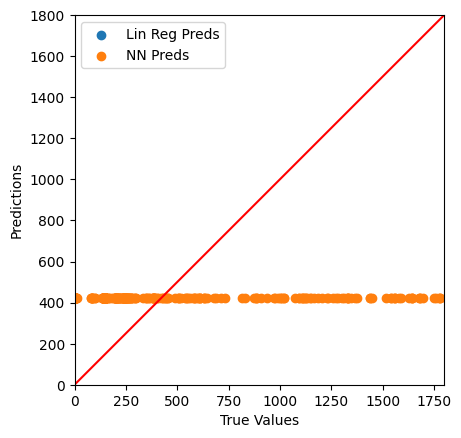

In [41]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")

Phishing emails supervised regression

In [42]:
df = pd.read_csv("Phishing.csv")

In [43]:
print("Existing column names:", df.columns)

Existing column names: Index(['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctEx

In [44]:
dataset_cols = [
    'id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT', 'CLASS_LABEL'
]

In [45]:
df.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


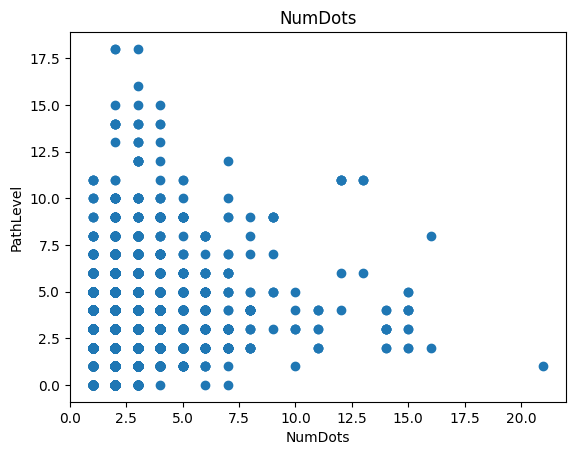

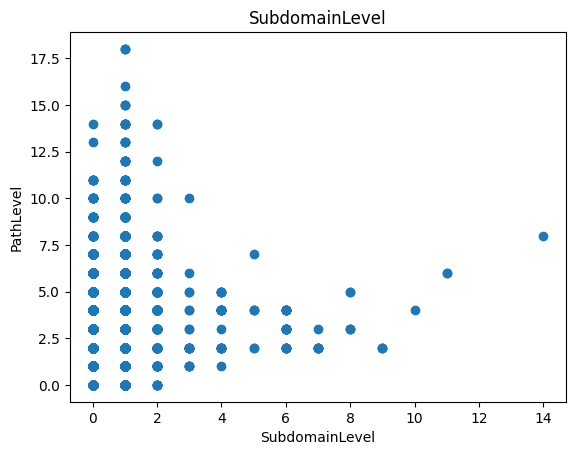

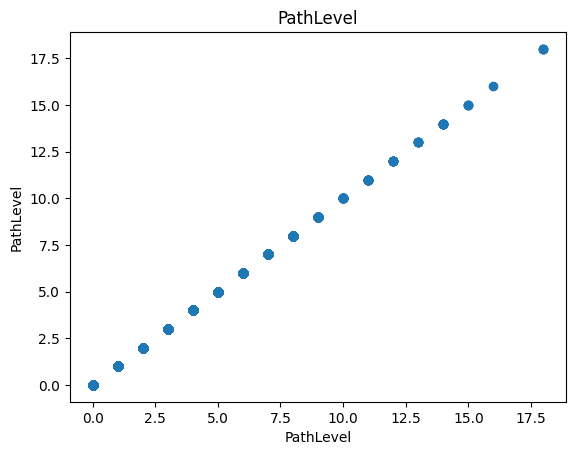

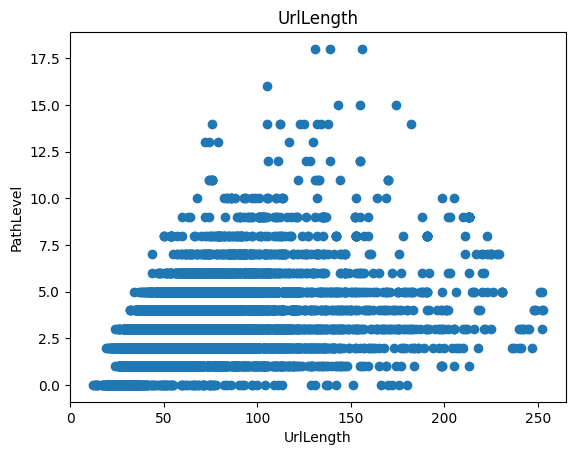

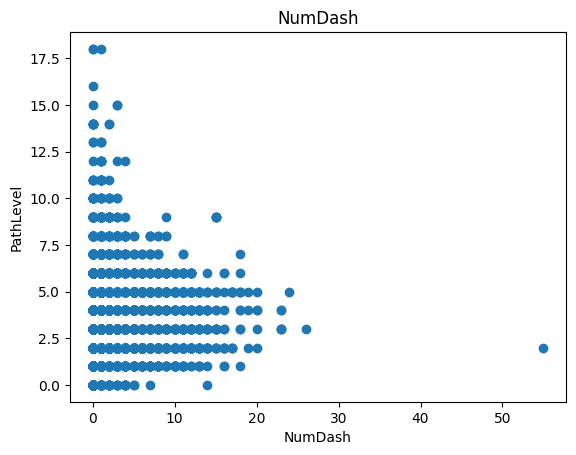

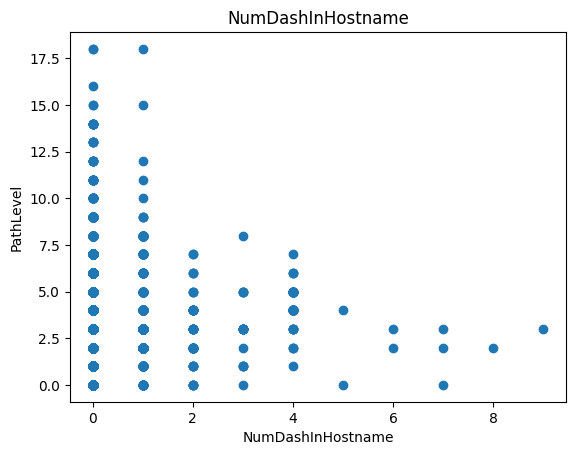

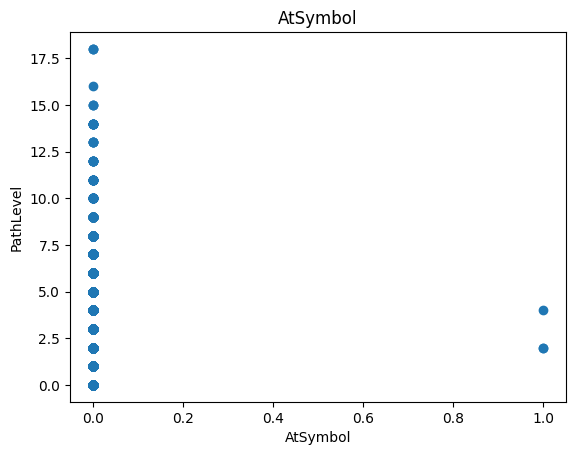

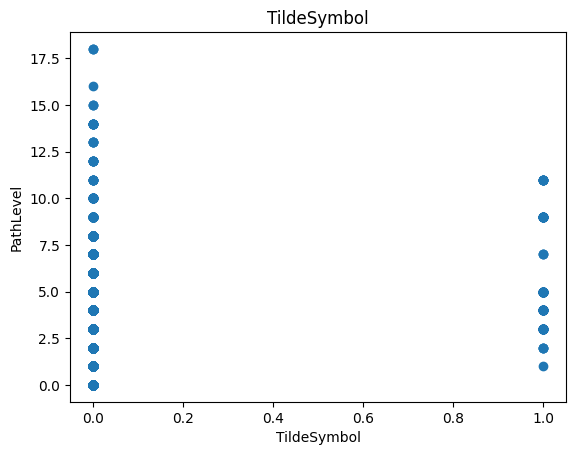

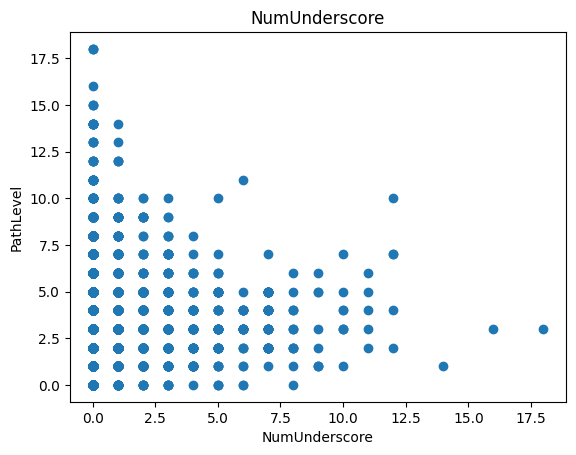

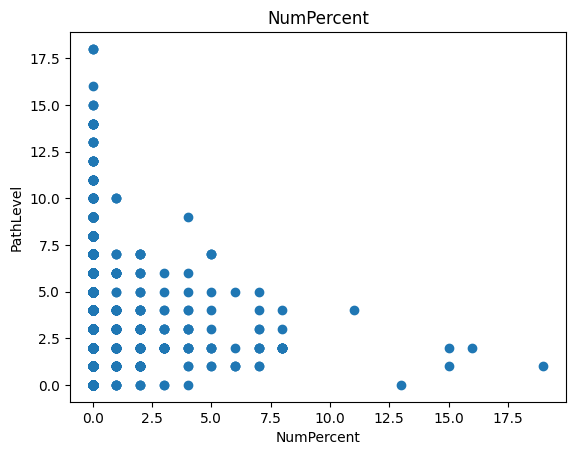

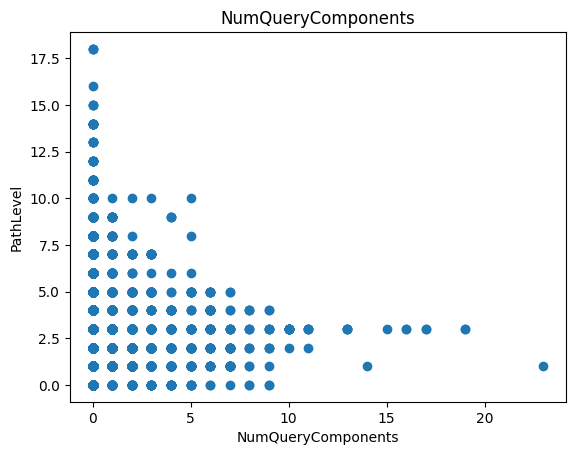

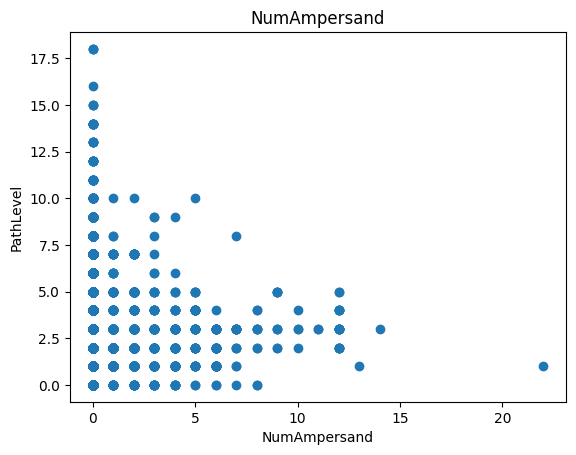

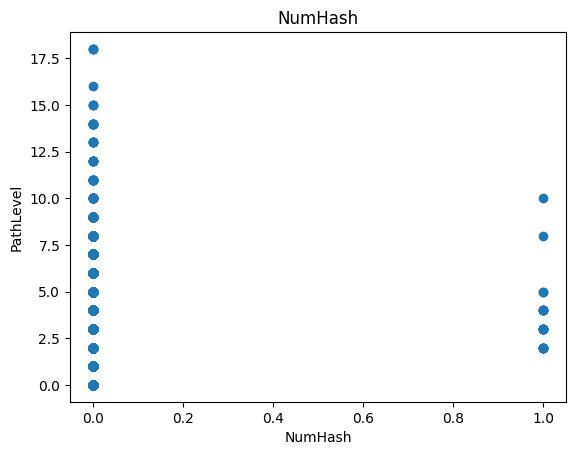

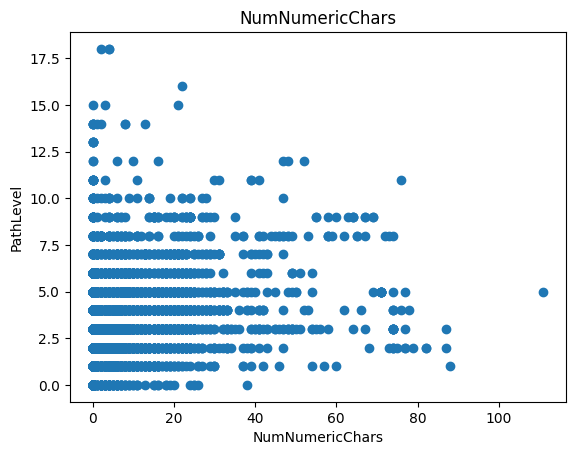

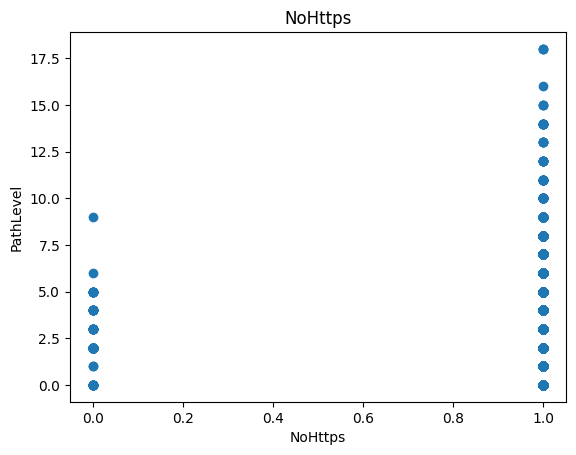

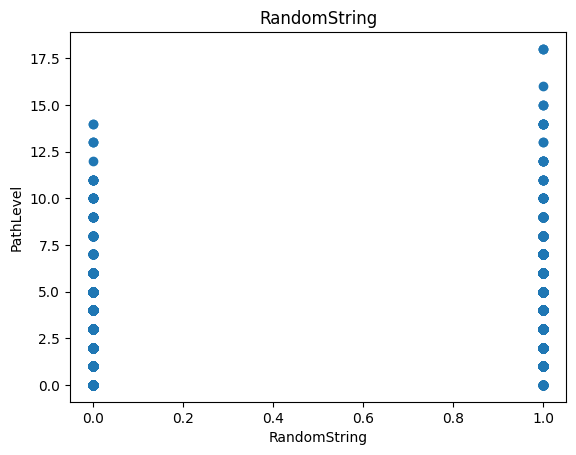

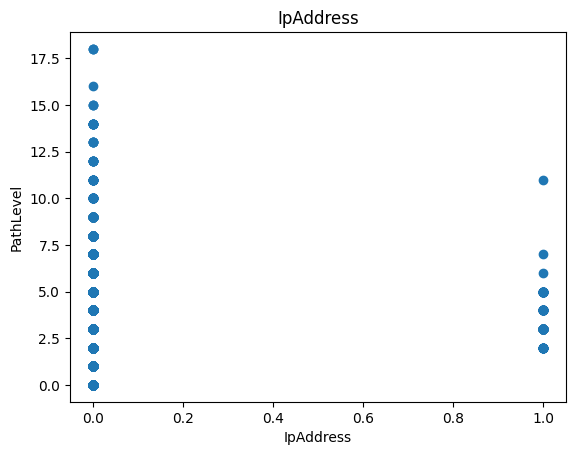

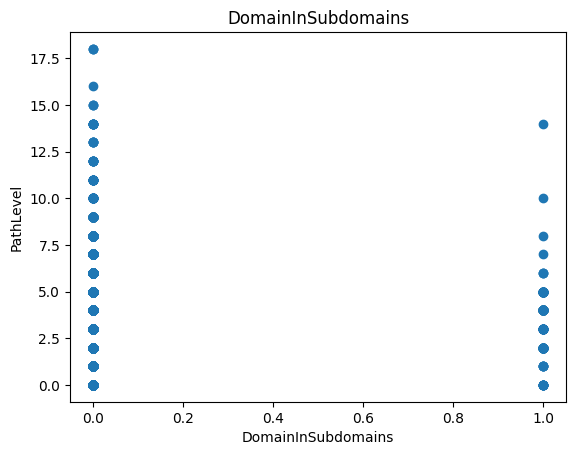

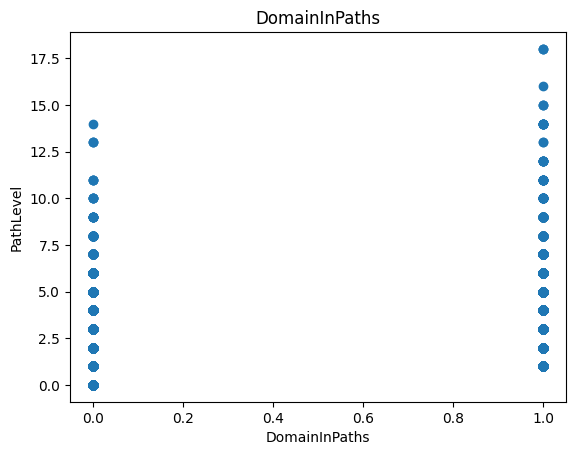

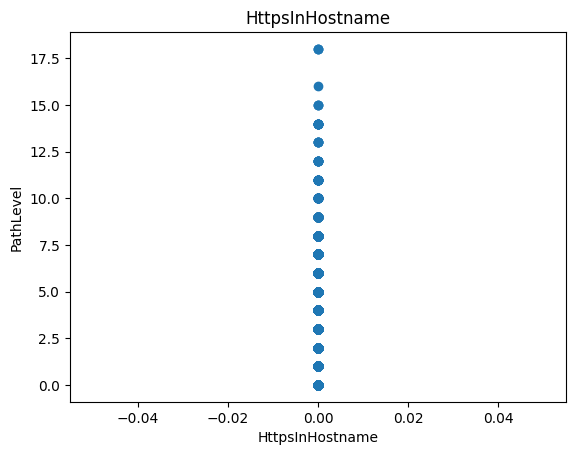

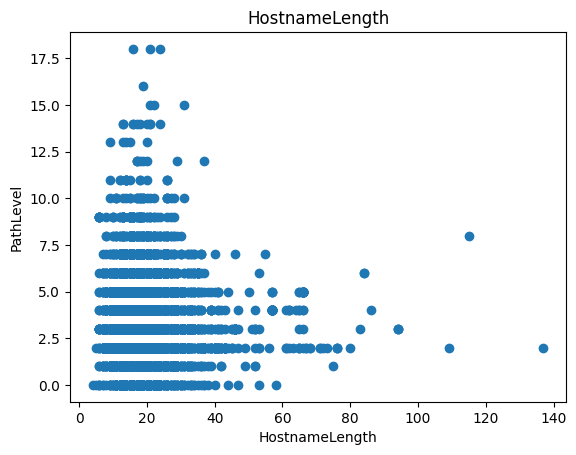

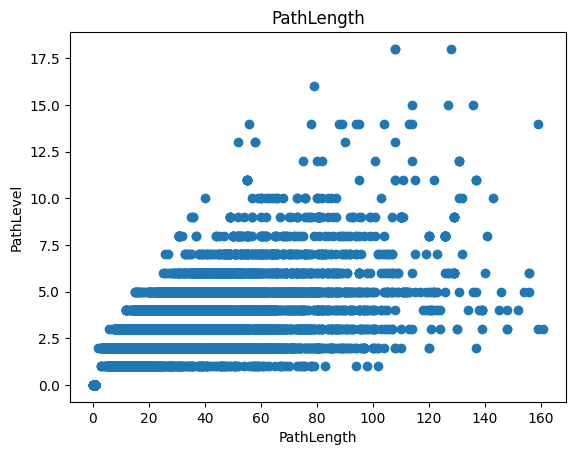

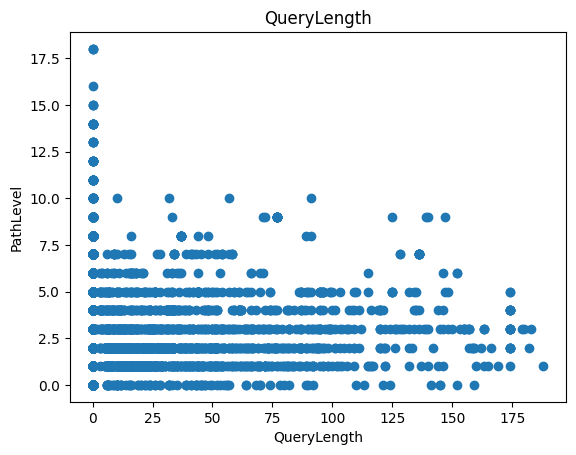

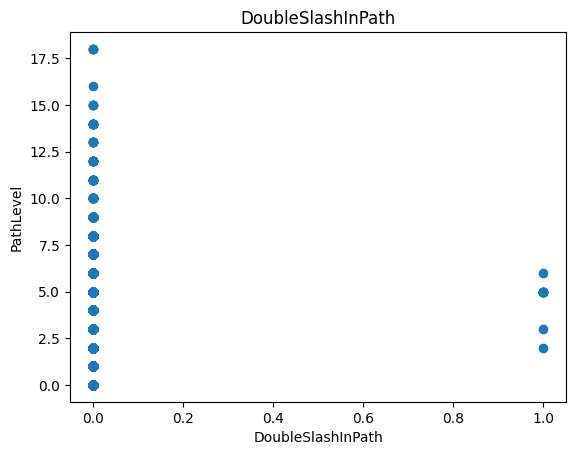

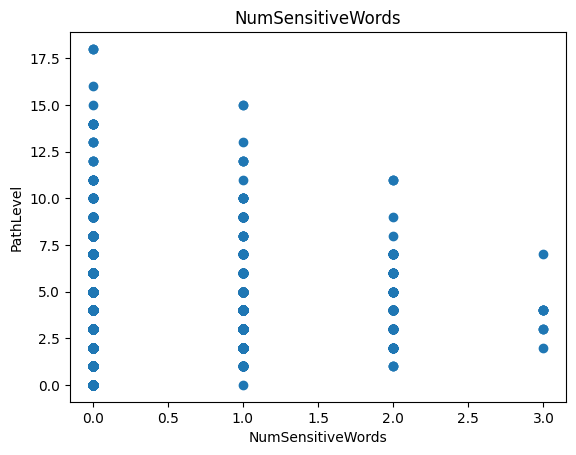

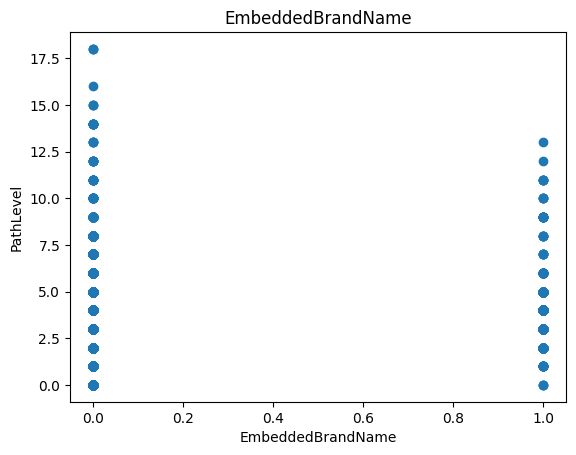

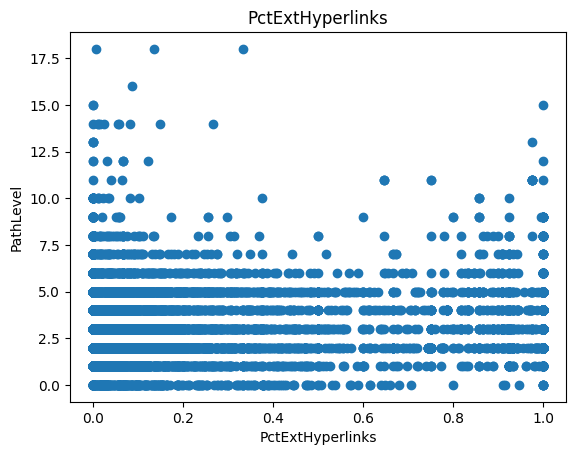

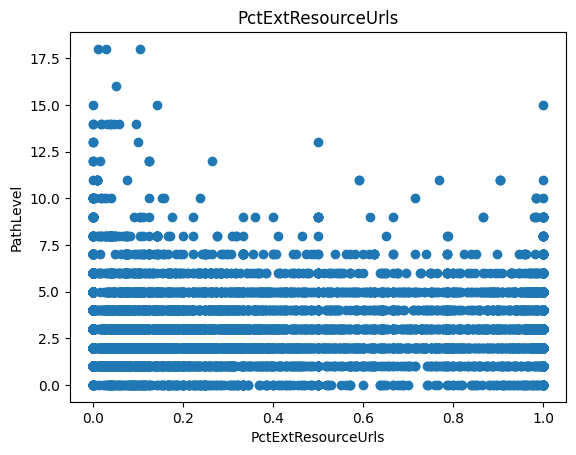

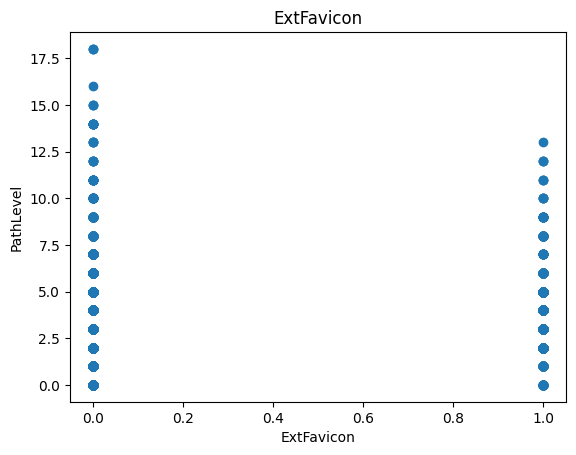

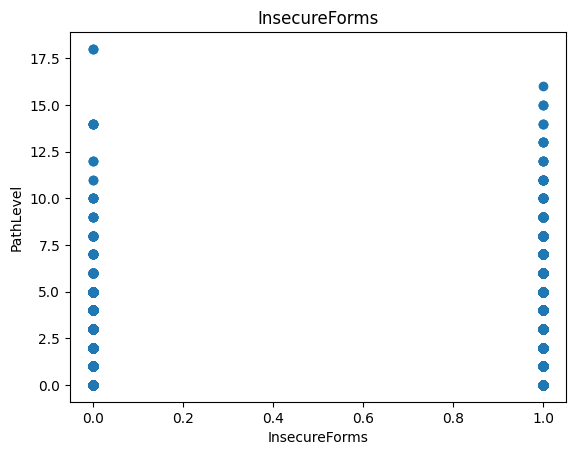

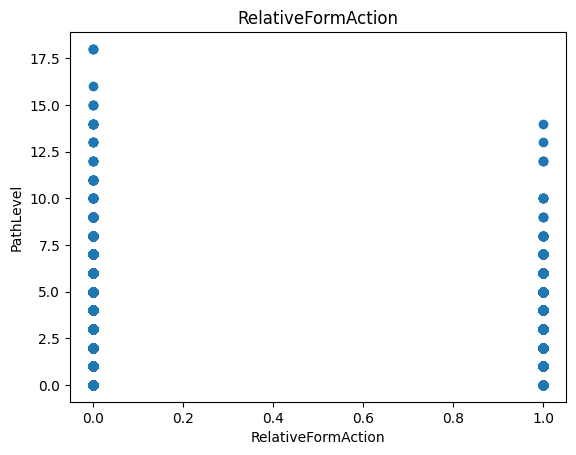

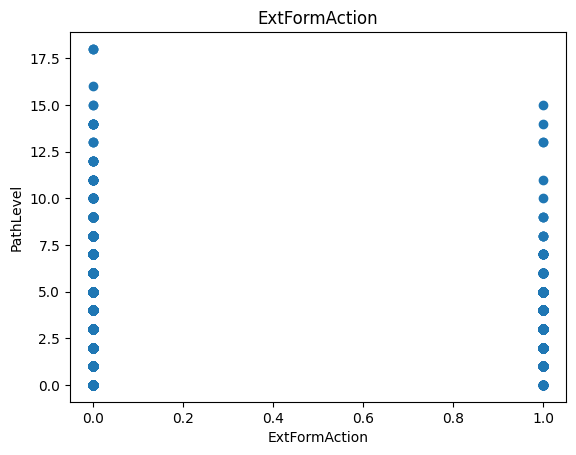

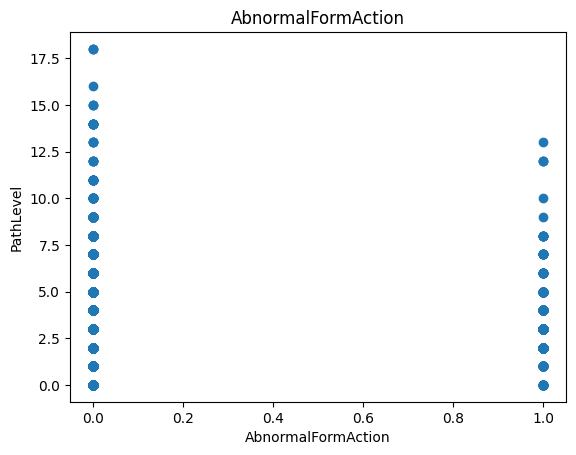

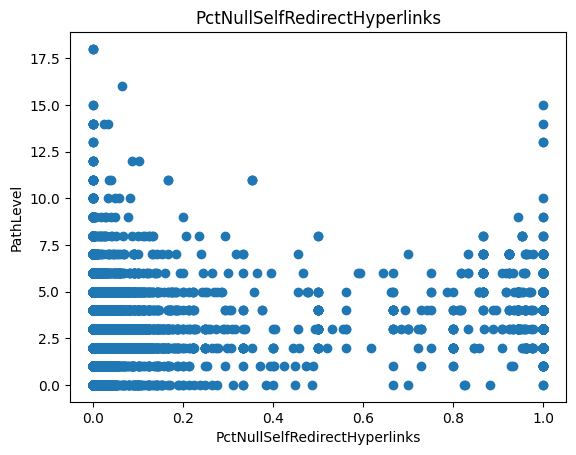

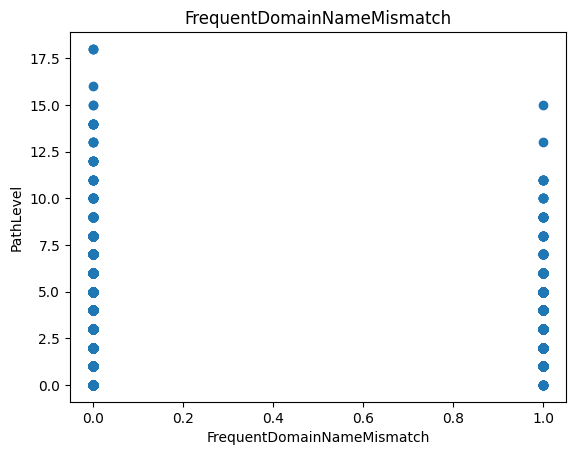

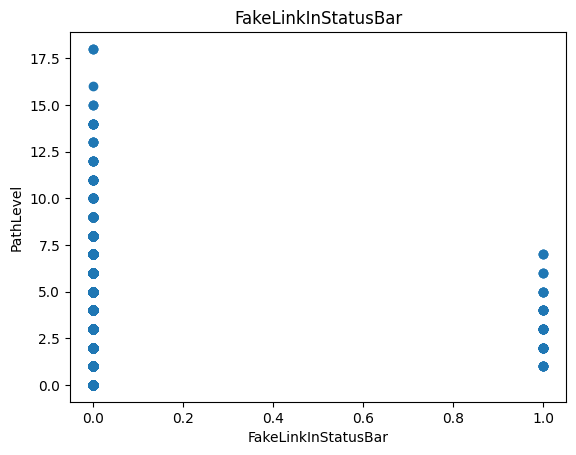

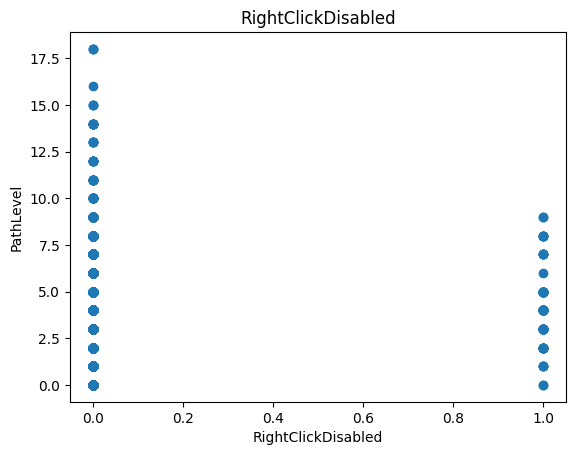

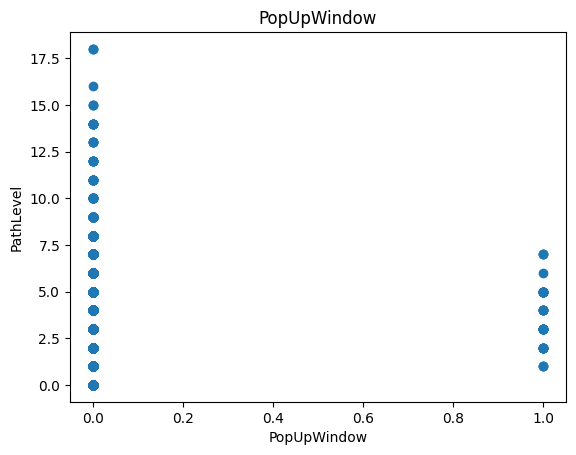

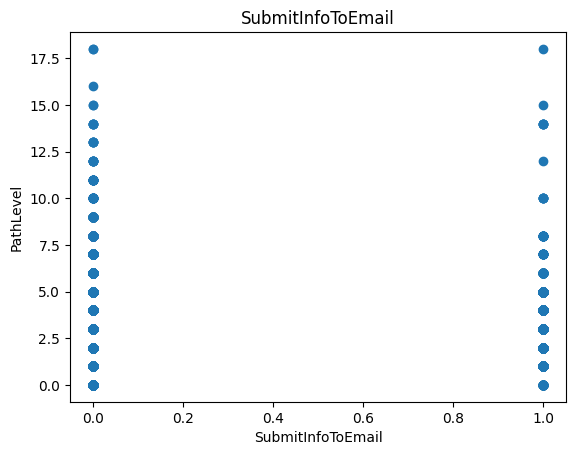

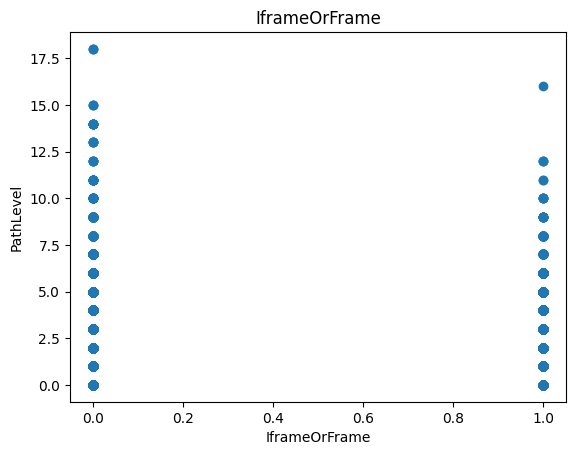

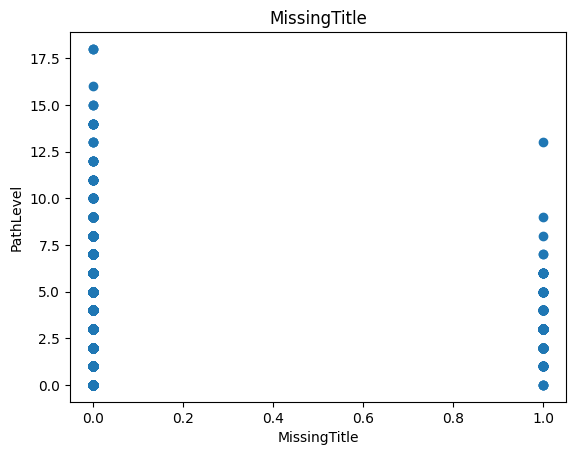

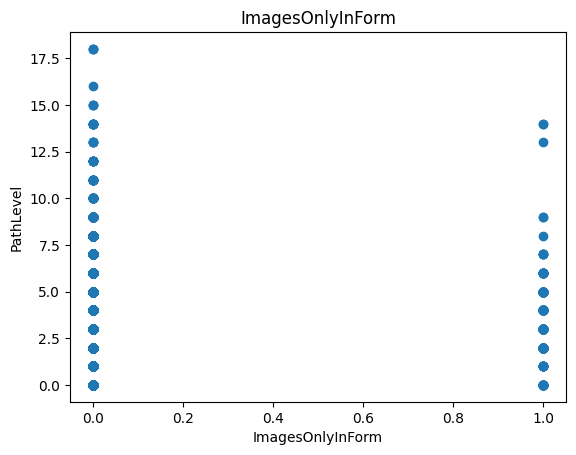

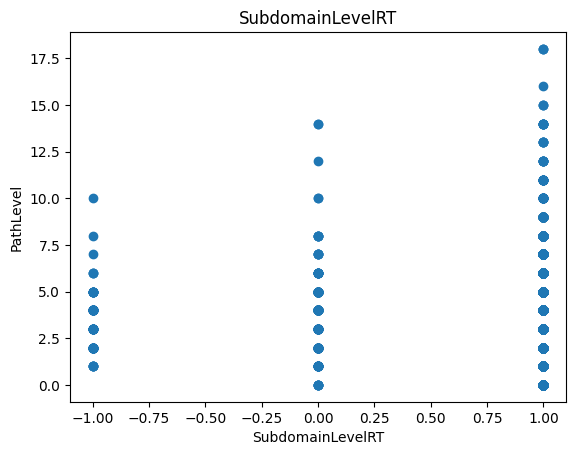

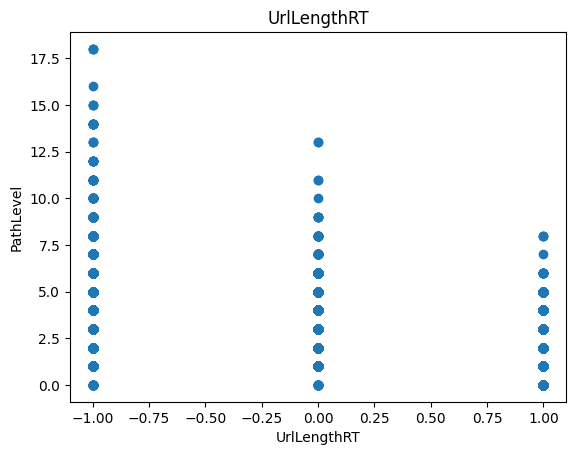

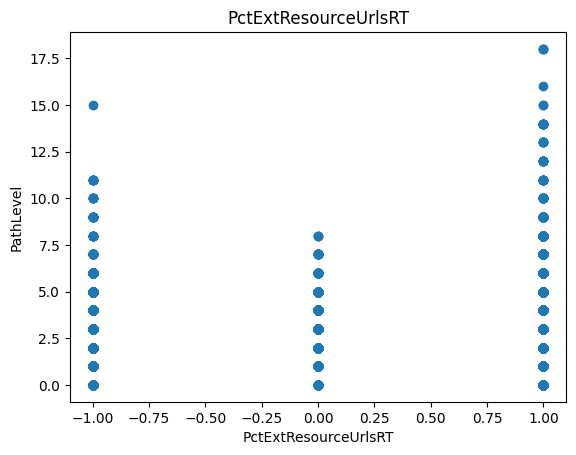

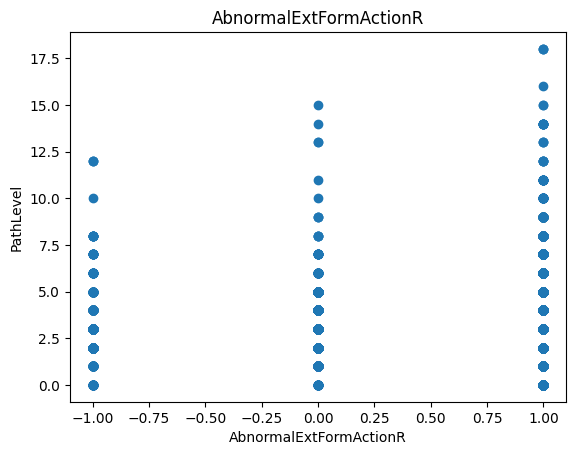

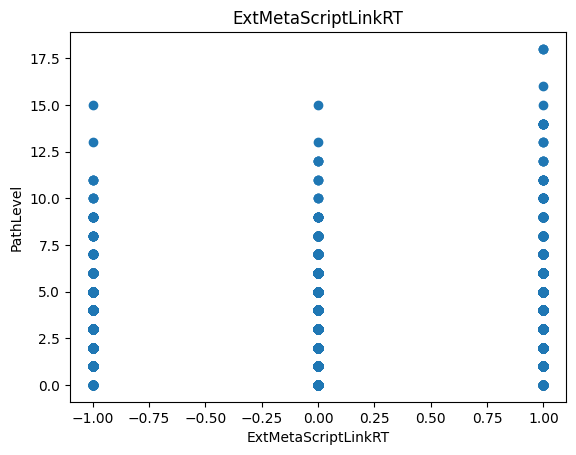

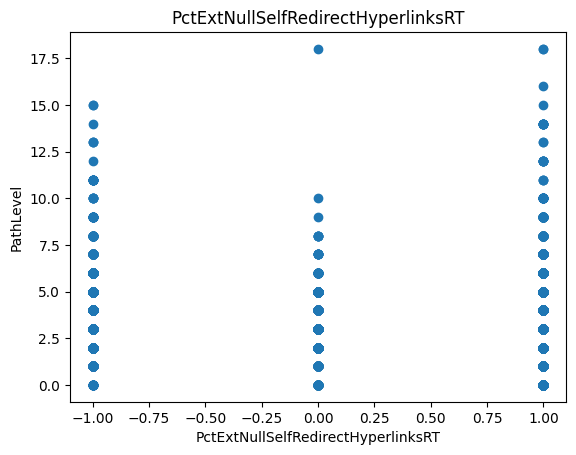

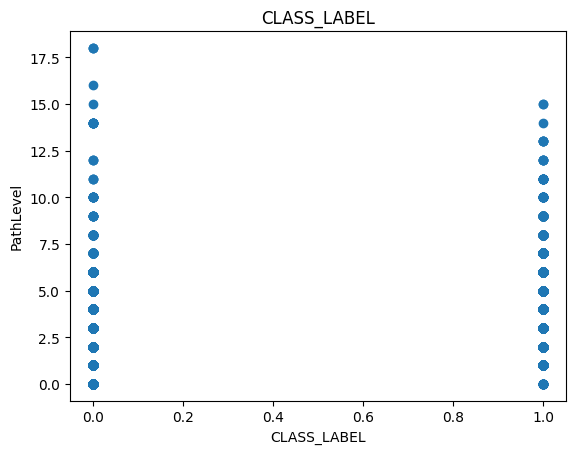

In [46]:
if len(df.columns) != len(dataset_cols): 
    print("Column count mismatch. Adjust the dataset_cols list or DataFrame.")
else:
    for label in df.columns[1:]:
        plt.scatter(df[label], df["PathLevel"])
        plt.title(label)
        plt.ylabel("PathLevel") 
        plt.xlabel(label)
        plt.show()

In [47]:
df.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [48]:
df = df.drop(["NumDash", "AtSymbol", "TildeSymbol"], axis=1)

In [49]:
df.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDashInHostname,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,2,0,2,1,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [50]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [51]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe) 
  if x_labels is None: 
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values 
  else:
    if len(x_labels) == 1: 
      X = dataframe[x_labels[0]].values.reshape(-1, 1) 
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y)) 
  return data, X, y

In [52]:
_, X_train, y_train = get_xy(train, "PathLevel", x_labels=["SubdomainLevel"]) 
_, X_val, y_val = get_xy(val, "PathLevel", x_labels=["SubdomainLevel"]) 
_, X_test, y_test = get_xy(test, "PathLevel", x_labels=["SubdomainLevel"])

In [53]:
train_reg = LinearRegression()
train_reg.fit(X_train, y_train)

LinearRegression()

In [54]:
train_reg.score(X_test, y_test)

-0.00042645761307080754

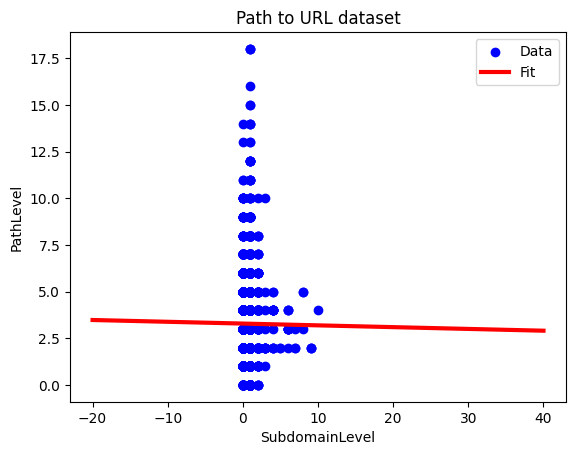

In [55]:
plt.scatter(X_train, y_train, label="Data", color="blue") 
x = tf.linspace(-20, 40, 200) 
plt.plot(x, train_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3) 
plt.legend() 
plt.title("Path to URL dataset") 
plt.ylabel("PathLevel") 
plt.xlabel("SubdomainLevel")
plt.show() 

In [56]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "SubdomainLevel", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "SubdomainLevel", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "SubdomainLevel", x_labels=df.columns[1:])

In [57]:
all_reg = LinearRegression() 
all_reg.fit(X_train, y_train_all)

LinearRegression()

In [58]:
all_reg.score(X_test, y_test)

-2.1486713199255294

In [59]:
y_pred_lr = all_reg.predict(X_test)

In [60]:
def plot_loss(history): 
  plt.plot(history.history['loss'], label='loss') 
  plt.plot(history.history['val_loss'], label='val_loss') 
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend() 
  plt.grid(True) 
  plt.show()

In [61]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) 
temp_normalizer.adapt(X_train.reshape(-1))

In [62]:
temp_nn_model = tf.keras.Sequential([ 
    temp_normalizer, 
    tf.keras.layers.Dense(1) 
])

In [63]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [64]:
history = temp_nn_model.fit( 
    X_train.reshape(-1), y_train, 
    verbose=0, 
    epochs=200, 
    validation_data=(X_val, y_val) 
)

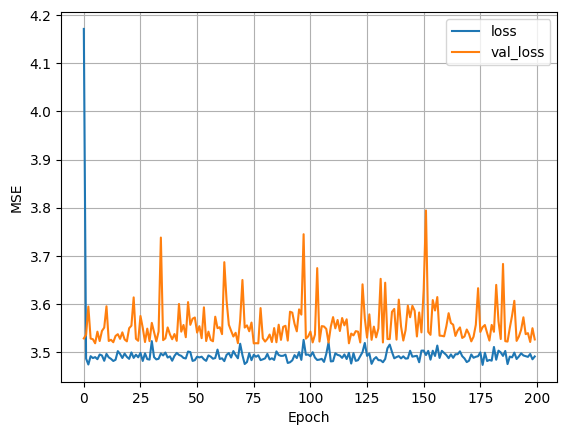

In [65]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


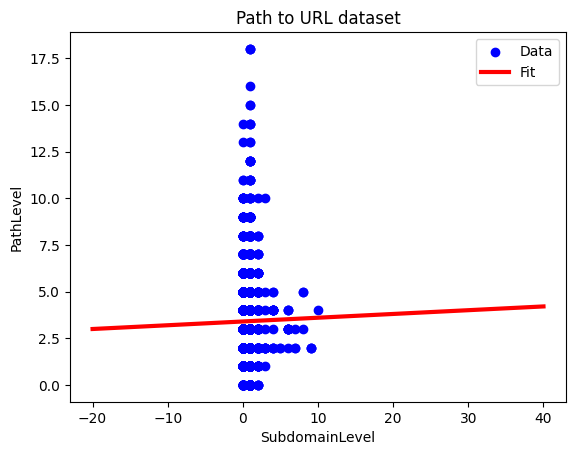

In [66]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = tf.linspace(-20, 40, 100) 
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Path to URL dataset")
plt.ylabel("PathLevel")
plt.xlabel("SubdomainLevel")
plt.show()

In [67]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) 
temp_normalizer.adapt(X_train.reshape(-1))

In [68]:
nn_model = tf.keras.Sequential([ 
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [69]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=200
)

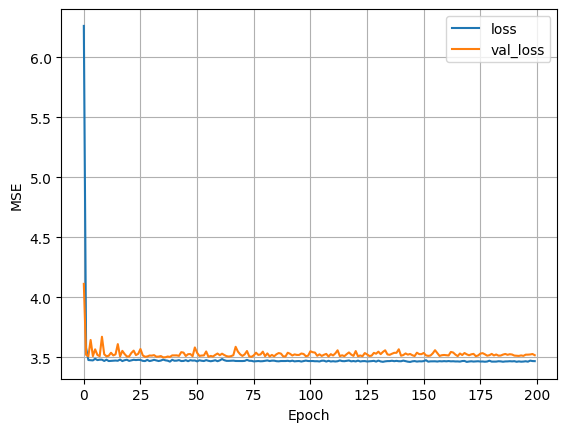

In [70]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


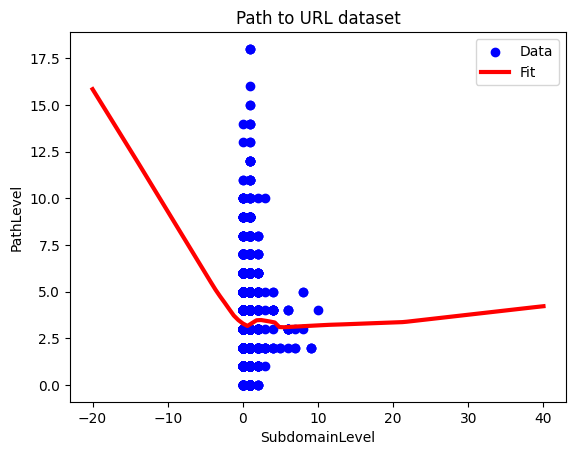

In [71]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Path to URL dataset")
plt.ylabel("PathLevel")
plt.xlabel("SubdomainLevel")
plt.show()

In [72]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1) 
all_normalizer.adapt(X_train)

In [73]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [74]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=100
)

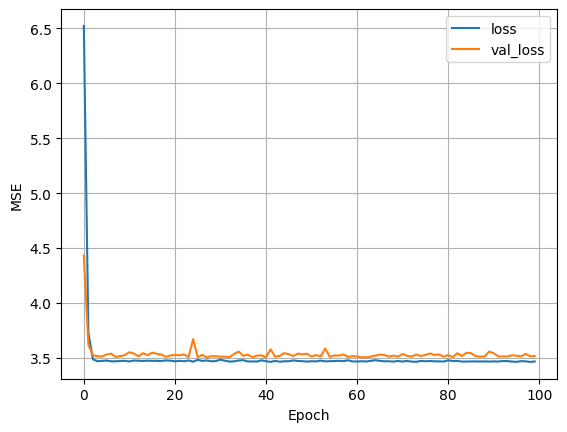

In [75]:
plot_loss(history)

In [76]:
_pred_lr = all_reg.predict(X_test) 
y_pred_nn = nn_model.predict(X_test)

63/63 [==============================] - 0s 582us/step


In [77]:
def MSE(y_pred, y_real): 
  return (np.square(y_pred - y_real)).mean()

In [78]:
MSE(y_pred_lr, y_test_all)

0.6185200054709574

In [79]:
MSE(y_pred_nn, y_test_all)

7.9373020898451525

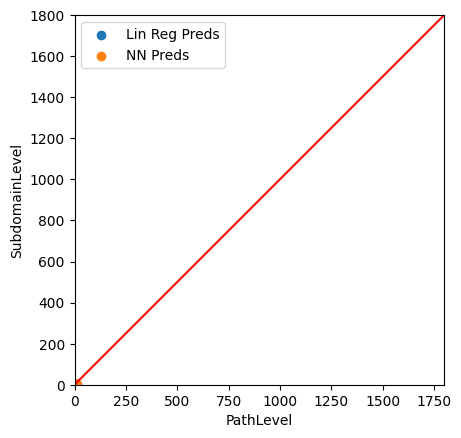

In [80]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("PathLevel")
plt.ylabel("SubdomainLevel")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")